In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Align crypto news (GDELT articles) with Binance candles on a chosen timeframe.

Main steps:
1) Load latest Binance candle CSV for a symbol.
2) Load normalized/unique news articles from a Parquet file.
3) Count news per time bin (hour/day/etc.) for a target symbol.
4) Resample candles to the same bin and merge -> a single aligned DataFrame.

Author: you :)
"""

from __future__ import annotations

import os
import glob
import ast
from typing import Iterable, List, Any, Tuple, Optional

import numpy as np
import pandas as pd
import prettytable

In [ ]:





# =========================
# ====== UTILITIES =========
# =========================
def ensure_list(obj: Any) -> List[str]:
    """
    Chuẩn hoá bất kỳ kiểu input thành list[str], phục vụ cho cột 'tokens' (có thể là str, list, tuple, ndarray).
    - None -> []
    - list/tuple/ndarray -> convert toàn bộ sang str
    - str -> thử parse literal (vd: "['btc', 'eth']"); nếu không parse được thì trả về [obj]
    - others -> [str(obj)]
    """
    if obj is None:
        return []
    if isinstance(obj, (list, tuple, np.ndarray)):
        return [str(x) for x in obj]
    if isinstance(obj, str):
        try:
            parsed = ast.literal_eval(obj)
            # Nếu parse ra không phải list/tuple, fallback về list một phần tử
            if isinstance(parsed, (list, tuple, np.ndarray)):
                return [str(x) for x in parsed]
            return [obj]
        except Exception:
            return [obj]
    return [str(obj)]


def latest_candle_csv_path(symbol: str, data_dir: str) -> str:
    """
    Lấy file CSV mới nhất theo pattern {symbol}_*.csv trong thư mục data_dir.
    Raise AssertionError nếu không tìm thấy file nào.
    """
    pattern = os.path.join(data_dir, f"{symbol}_*.csv")
    files = sorted(glob.glob(pattern))
    assert files, f"Không thấy file cho {symbol} trong {data_dir}"
    return files[-1]


# =========================
# ====== LOADERS ==========
# =========================
def load_candles(symbol: str, data_dir: str) -> pd.DataFrame:
    """
    Đọc candle CSV mới nhất cho symbol từ data_dir và chuẩn hoá cột:
    - phải có 'open_time' (UTC, datetime64[ns, UTC])
    - cột giá/khối lượng được rename về: open, high, low, close, volume
    Trả về DataFrame đã sort theo thời gian, chỉ giữ các cột cần thiết.
    """
    fp = latest_candle_csv_path(symbol, data_dir)
    df = pd.read_csv(fp)

    # ---- Đảm bảo có 'open_time' ----
    # Một số source có thể đặt tên 'Open time', 'openTime', ...
    if "open_time" not in df.columns:
        # tìm cột chứa 'open' và 'time' (case-insensitive)
        time_candidates = [c for c in df.columns if ("open" in c.lower()) and ("time" in c.lower())]
        if time_candidates:
            df = df.rename(columns={time_candidates[0]: "open_time"})
        else:
            raise ValueError("Không tìm thấy cột 'open_time' hoặc tương đương trong CSV.")

    # ---- Convert timezone-aware datetime (UTC) ----
    df["open_time"] = pd.to_datetime(df["open_time"], utc=True, errors="coerce")
    if df["open_time"].isna().any():
        raise ValueError("Có giá trị open_time không parse được sang datetime.")

    # ---- Chuẩn hoá tên cột OHLCV (nếu đang viết hoa) ----
    rename_map = {"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"}
    df = df.rename(columns=rename_map)

    # ---- Một số file có thể dùng lowercase sẵn hoặc tên hơi khác, xử lý nhẹ nhàng ----
    # (ưu tiên giữ nguyên nếu đã đúng)
    for k in ["open", "high", "low", "close", "volume"]:
        if k not in df.columns:
            # cố gắng map mềm theo lower()
            lower_map = {c.lower(): c for c in df.columns}
            if k in lower_map:
                df = df.rename(columns={lower_map[k]: k})
            else:
                raise ValueError(f"Thiếu cột '{k}' trong CSV.")

    # ---- Giữ đúng cột và sort theo thời gian ----
    cols = ["open_time", "open", "high", "low", "close", "volume"]
    out = df[cols].sort_values("open_time").reset_index(drop=True)
    return out


def load_news_articles(parquet_fp: str) -> pd.DataFrame:
    """
    Đọc parquet articles (đã normalized/unique).
    Yêu cầu cột 'seendate' (UTC) tồn tại và parse được.
    """
    df = pd.read_parquet(parquet_fp)
    if "seendate" not in df.columns:
        raise ValueError("Thiếu cột 'seendate' trong articles parquet.")
    df["seendate"] = pd.to_datetime(df["seendate"], utc=True, errors="coerce")
    if df["seendate"].isna().any():
        raise ValueError("Có giá trị seendate không parse được sang datetime.")
    return df


# =========================
# ===== PROCESSING =========
# =========================
def build_news_counts(
    articles_df: pd.DataFrame,
    symbol: str,
    tf: str = "1h",
    main_symbol_col: str = "main_symbol",
    tokens_col: str = "tokens",
) -> pd.DataFrame:
    """
    Lọc bài viết theo symbol và tính số lượng bài theo time bin.

    Quy ước:
    - Với symbol như 'BTCUSDT' -> base = 'BTC'
    - cond_main: hàng có main_symbol == base (case-insensitive)
    - cond_tokens: base xuất hiện trong cột tokens (đã chuẩn hoá ensure_list, so sánh uppercase)
    - time_bin = floor(seendate, tf)

    Trả về DataFrame có index là time_bin và 1 cột 'news_count'.
    """
    base = symbol.replace("USDT", "").upper()  # 'BTCUSDT' -> 'BTC'
    if main_symbol_col not in articles_df.columns:
        raise ValueError(f"Thiếu cột '{main_symbol_col}' trong articles_df.")
    if tokens_col not in articles_df.columns:
        raise ValueError(f"Thiếu cột '{tokens_col}' trong articles_df.")

    # ---- Điều kiện lọc chính (main_symbol hoặc tokens có chứa base) ----
    cond_main = articles_df[main_symbol_col].astype(str).str.upper().eq(base)
    cond_tokens = articles_df[tokens_col].apply(lambda xs: base in [s.upper() for s in ensure_list(xs)])

    df = articles_df[cond_main | cond_tokens].copy()
    if df.empty:
        # Không có bài nào cho symbol -> trả DataFrame rỗng với đúng tên cột
        return pd.DataFrame(columns=["news_count"]).astype({"news_count": "int64"})

    # ---- Gộp theo time bin (floor) ----
    df["time_bin"] = df["seendate"].dt.floor(tf)
    news_counts = df.groupby("time_bin").size().rename("news_count").to_frame()
    return news_counts


def align_news_vs_price(
    candle_df: pd.DataFrame,
    news_counts: pd.DataFrame,
    tf: str = "1h",
) -> pd.DataFrame:
    """
    Resample candles về tf và merge với news_counts theo index thời gian.

    Candle resample:
      - close: lấy giá cuối bin (last)
      - volume: tổng volume trong bin (sum)
      - ret: log-return của close theo bin (diff log(close))

    Kết quả:
      - cột 'time' (datetime, UTC)
      - close, volume, ret, news_count (news_count điền 0 nếu NaN)
    """
    # ---- Đặt index là open_time để resample ----
    c = candle_df.set_index("open_time")

    # ---- Resample OHLCV về cùng tf ----
    c_res = pd.DataFrame({
        "close": c["close"].resample(tf).last(),
        "volume": c["volume"].resample(tf).sum(),
    }).dropna()  # bỏ bin không đủ dữ liệu

    # ---- Tính log-return ----
    c_res["ret"] = np.log(c_res["close"]).diff()

    # ---- Merge left join theo time index ----
    # news_counts có index là 'time_bin', c_res có index là thời gian resample
    out = c_res.merge(news_counts, left_index=True, right_index=True, how="left")

    # ---- Điền 0 cho bin không có news ----
    out = out.fillna({"news_count": 0})

    # ---- Trả về dạng 'time' là cột thay vì index ----
    out = out.reset_index(names="time")
    return out




In [3]:

# =========================
# ======= CONFIG ==========
# =========================
SYMBOL: str      = "BTCUSDT"   # Binance symbol
TF_ALIGN: str    = "1h"        # pandas offset alias: '1h' (hourly) | '1D' (daily) | '15T', ...
CANDLE_DIR: str  = "../../work/data/binance/spot/1m"
ARTICLES_FP: str = "../../work/data/gdelt_0024_hardfix_split/normalized_unique/articles.parquet"


def run(
    symbol: str = SYMBOL,
    tf_align: str = TF_ALIGN,
    candle_dir: str = CANDLE_DIR,
    articles_fp: str = ARTICLES_FP,
) -> pd.DataFrame:
    """
    Pipeline tổng:
    1) load candles (min-level) -> resample
    2) load articles parquet
    3) build news counts theo tf_align
    4) merge
    """
    candles = load_candles(symbol, candle_dir)
    articles = load_news_articles(articles_fp)
    news_counts = build_news_counts(articles, symbol, tf=tf_align)
    aligned = align_news_vs_price(candles, news_counts, tf=tf_align)
    return aligned


# if __name__ == "__main__":
# Ví dụ chạy nhanh: python align_news_price.py
df_aligned = run(SYMBOL, TF_ALIGN, CANDLE_DIR, ARTICLES_FP)
print(df_aligned.head(10))
print("\nShape:", df_aligned.shape)

                       time    close       volume       ret  news_count
0 2019-01-01 00:00:00+00:00  3700.31   686.367420       NaN         0.0
1 2019-01-01 01:00:00+00:00  3689.69   613.539115 -0.002874         0.0
2 2019-01-01 02:00:00+00:00  3690.00   895.302181  0.000084         0.0
3 2019-01-01 03:00:00+00:00  3693.13   796.714818  0.000848         0.0
4 2019-01-01 04:00:00+00:00  3692.71  1317.452909 -0.000114         0.0
5 2019-01-01 05:00:00+00:00  3699.94   572.402228  0.001956         0.0
6 2019-01-01 06:00:00+00:00  3703.56   660.279771  0.000978         0.0
7 2019-01-01 07:00:00+00:00  3713.83   823.625491  0.002769         0.0
8 2019-01-01 08:00:00+00:00  3716.70   887.101362  0.000772         0.0
9 2019-01-01 09:00:00+00:00  3699.95   955.879034 -0.004517         0.0

Shape: (58464, 5)


In [5]:
# Filter df_aligned where news_count > 0
df_filtered = df_aligned[df_aligned["news_count"] > 0]
print("\nFiltered (news_count > 0) Shape:", df_filtered.shape)

# prettytable
pt = prettytable.PrettyTable()
pt.field_names = ["time", "close", "volume", "ret", "news_count"]
for _, row in df_filtered.head(10).iterrows():
    pt.add_row([row["time"], row["close"], row["volume"], row["ret"], int(row["news_count"])])
print("\nTop 10 rows with news_count > 0:")
print(pt)



Filtered (news_count > 0) Shape: (24353, 5)

Top 10 rows with news_count > 0:
+---------------------------+----------+-------------+------------------------+------------+
|            time           |  close   |    volume   |          ret           | news_count |
+---------------------------+----------+-------------+------------------------+------------+
| 2020-08-11 00:00:00+00:00 | 11872.0  |  1921.11203 | -0.0017605786515346722 |     3      |
| 2020-08-11 01:00:00+00:00 | 11927.99 | 2129.366132 |  0.004705052673546817  |     1      |
| 2020-08-11 02:00:00+00:00 | 11853.26 | 2250.705596 | -0.006284803866773103  |     1      |
| 2020-08-11 03:00:00+00:00 | 11833.81 | 2433.622965 |  -0.00164224653968148  |     1      |
| 2020-08-11 08:00:00+00:00 | 11712.94 | 2730.235999 | -0.0029930558097284177 |     2      |
| 2020-08-11 09:00:00+00:00 | 11695.9  | 3222.669977 | -0.001455860521899055  |     6      |
| 2020-08-11 10:00:00+00:00 | 11729.22 | 3986.433533 |  0.002844811251462076  |     

In [ ]:
# Filter df_aligned where news_count > 0

percentile = 90

for perceintile in [75, 80, 85, 90, 95]:
    percentile_news_count = np.percentile(df_aligned["news_count"], perceintile)
    print(f"\n{perceintile}th Percentile of news_count: {percentile_news_count}")

    df_filtered = df_aligned[df_aligned["news_count"] > percentile_news_count]
    print(f"Filtered (news_count > p{perceintile}) Shape:", df_filtered.shape)



90th Percentile of news_count: 6.0

Filtered (news_count > p90) Shape: (4672, 5)


In [ ]:
# ==== RUN ====
TF         = "1h"        # time frame align
candles = load_candles(SYMBOL, CANDLE_DIR)
articles_df = load_news_articles(ARTICLES_FP)
news_counts = build_news_counts(articles_df, SYMBOL, TF)
aligned = align_news_vs_price(candles, news_counts, TF)

print(aligned.head(10))
print("\nCorrelation:", aligned[["ret","news_count"]].corr().iloc[0,1])

                       time    close       volume       ret  news_count
0 2019-01-01 00:00:00+00:00  3700.31   686.367420       NaN         0.0
1 2019-01-01 01:00:00+00:00  3689.69   613.539115 -0.002874         0.0
2 2019-01-01 02:00:00+00:00  3690.00   895.302181  0.000084         0.0
3 2019-01-01 03:00:00+00:00  3693.13   796.714818  0.000848         0.0
4 2019-01-01 04:00:00+00:00  3692.71  1317.452909 -0.000114         0.0
5 2019-01-01 05:00:00+00:00  3699.94   572.402228  0.001956         0.0
6 2019-01-01 06:00:00+00:00  3703.56   660.279771  0.000978         0.0
7 2019-01-01 07:00:00+00:00  3713.83   823.625491  0.002769         0.0
8 2019-01-01 08:00:00+00:00  3716.70   887.101362  0.000772         0.0
9 2019-01-01 09:00:00+00:00  3699.95   955.879034 -0.004517         0.0

Correlation: 0.0016118095547926214


[EventStudy] Events selected: 5157  (use_spike=False, min_gap_h=6)
[EventStudy] Paths kept: 5155 | Control paths: 2000
[EventStudy] At t=0h:    mean_logCum=+0.00042 vs ctrl=+0.00042 | z=+0.01, p≈0.9892
[EventStudy] At t=+24h: mean_logCum=+0.00175 vs ctrl=+0.00266 | z=-0.95, p≈0.3407


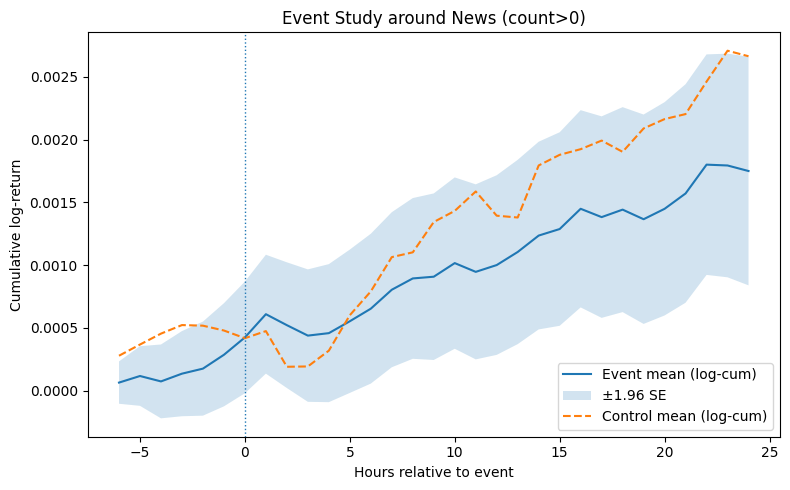

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Iterable, Tuple

# ===================== CONFIG =====================
TF_LOWER = "1h"     # dùng chữ thường để tránh FutureWarning
PRE_H    = 6        # số giờ trước event (K-)
POST_H   = 24       # số giờ sau event (K+)
USE_SPIKE = False   # True: chỉ lấy event có news_spike=True; False: news_count>0
MIN_GAP  = 6        # tối thiểu cách nhau bao nhiêu giờ để coi là 2 event khác nhau
N_CONTROL = 2000    # số cửa sổ control để bootstrap baseline
RANDOM_SEED = 42

# ================== CORE UTILITIES =================
def _select_events(aligned: pd.DataFrame,
                   use_spike: bool = False,
                   min_gap_hours: int = 6) -> pd.DatetimeIndex:
    """
    Chọn các mốc event (UTC) từ aligned:
      - use_spike=True: event là các bin có news_spike=True
      - use_spike=False: event là các bin có news_count>0
    Gộp những event quá gần nhau (within min_gap_hours) thành 1 (lấy mốc đầu).
    """
    cond = aligned["news_spike"] if use_spike and "news_spike" in aligned.columns else (aligned["news_count"] > 0)
    t = aligned.loc[cond, "time"].sort_values().reset_index(drop=True)
    if t.empty:
        return pd.DatetimeIndex([])
    # gộp event gần nhau
    kept = [t.iloc[0]]
    for ts in t.iloc[1:]:
        if (ts - kept[-1]) >= pd.Timedelta(hours=min_gap_hours):
            kept.append(ts)
    return pd.DatetimeIndex(kept)

def _event_matrix_from_returns(aligned: pd.DataFrame,
                               events: Iterable[pd.Timestamp],
                               pre_h: int,
                               post_h: int) -> Tuple[np.ndarray, pd.TimedeltaIndex]:
    """
    Tạo ma trận (n_event, window_len) của cumulative log-return quanh mỗi event.
    - Dùng cột 'ret' (log-return) trên index thời gian theo TF.
    - Tính cumulative sum từ -pre_h..+post_h → chuyển sang *cumulative simple return* nếu muốn.
    Trả về:
      mat_logcum: cumulative *log* return (shape n x L)
      offsets:    index thời gian tương đối (TimdeltaIndex)
    """
    df = aligned.set_index("time").sort_index()
    # đảm bảo đều đặn theo TF
    df = df.asfreq(TF_LOWER)
    rets = df["ret"].copy()

    offsets = pd.timedelta_range(start=f"-{pre_h}h", end=f"{post_h}h", freq=TF_LOWER)
    L = len(offsets)
    mats = []

    for ev in events:
        idxs = ev + offsets
        if not idxs.isin(rets.index).all():
            # bỏ event nếu thiếu dữ liệu ở rìa
            continue
        # cumulative log-return từ t=-pre..current..+post
        log_path = rets.reindex(idxs).fillna(0.0).to_numpy().cumsum()
        mats.append(log_path)

    if not mats:
        return np.empty((0, L)), offsets
    return np.vstack(mats), offsets

def _bootstrap_control(aligned: pd.DataFrame,
                       n_control: int,
                       pre_h: int,
                       post_h: int,
                       rng: np.random.Generator) -> np.ndarray:
    """
    Lấy ngẫu nhiên các mốc thời gian (không dùng news), tạo ma trận cumulative log-return
    để làm baseline control.
    """
    df = aligned.set_index("time").sort_index().asfreq(TF_LOWER)
    times = df.index
    # tránh rìa
    start = times.min() + pd.Timedelta(hours=pre_h)
    end   = times.max() - pd.Timedelta(hours=post_h)
    valid = times[(times >= start) & (times <= end)]
    if len(valid) == 0:
        return np.empty((0, pre_h + post_h + 1))

    picks = rng.choice(valid, size=min(n_control, len(valid)), replace=False)
    mat, _ = _event_matrix_from_returns(aligned, picks, pre_h, post_h)
    return mat

# ================== EVENT STUDY MAIN ================
def event_study(aligned: pd.DataFrame,
                use_spike: bool = False,
                pre_h: int = 6,
                post_h: int = 24,
                min_gap_hours: int = 6,
                n_control: int = 2000,
                seed: int = 42,
                plot: bool = True):
    """
    Chạy event study:
      1) Chọn events theo news.
      2) Tạo ma trận cumulative log-return quanh event.
      3) Tạo control windows ngẫu nhiên.
      4) In thống kê & (tuỳ chọn) plot mean ± 1.96*SE.
    """
    rng = np.random.default_rng(seed)

    # 1) Events
    events = _select_events(aligned, use_spike=use_spike, min_gap_hours=min_gap_hours)
    print(f"[EventStudy] Events selected: {len(events)}  (use_spike={use_spike}, min_gap_h={min_gap_hours})")

    # 2) Event matrix
    ev_mat, offsets = _event_matrix_from_returns(aligned, events, pre_h, post_h)
    L = len(offsets)
    if ev_mat.shape[0] == 0:
        print("[EventStudy] Không đủ dữ liệu tạo paths quanh event (có thể do rìa).")
        return

    # 3) Control baseline
    ctrl_mat = _bootstrap_control(aligned, n_control=n_control, pre_h=pre_h, post_h=post_h, rng=rng)

    # Mean & CI (log domain)
    ev_mean = ev_mat.mean(axis=0)
    ev_se   = ev_mat.std(axis=0, ddof=1) / np.sqrt(ev_mat.shape[0])
    ctrl_mean = ctrl_mat.mean(axis=0) if ctrl_mat.size else np.zeros(L)
    ctrl_se   = (ctrl_mat.std(axis=0, ddof=1) / np.sqrt(ctrl_mat.shape[0])) if ctrl_mat.size else np.zeros(L)

    # p-value thô tại mốc 0h và tại cuối cửa sổ (simple z-test vs control mean)
    def z_p(mu1, se1, mu0, se0):
        se = np.sqrt(se1**2 + se0**2 + 1e-12)
        z = (mu1 - mu0) / se
        # two-sided p (xấp xỉ)
        from math import erf, sqrt
        p = 2*(1 - 0.5*(1+erf(abs(z)/sqrt(2))))
        return z, p

    zero_idx = pre_h  # vị trí t=0
    z0, p0 = z_p(ev_mean[zero_idx], ev_se[zero_idx], ctrl_mean[zero_idx], ctrl_se[zero_idx])
    zT, pT = z_p(ev_mean[-1], ev_se[-1], ctrl_mean[-1], ctrl_se[-1])

    # In thống kê
    print(f"[EventStudy] Paths kept: {ev_mat.shape[0]} | Control paths: {ctrl_mat.shape[0]}")
    print(f"[EventStudy] At t=0h:    mean_logCum={ev_mean[zero_idx]:+.5f} vs ctrl={ctrl_mean[zero_idx]:+.5f} | z={z0:+.2f}, p≈{p0:.4f}")
    print(f"[EventStudy] At t=+{post_h}h: mean_logCum={ev_mean[-1]:+.5f} vs ctrl={ctrl_mean[-1]:+.5f} | z={zT:+.2f}, p≈{pT:.4f}")

    # (Optional) convert log-cum to simple-cum: R = exp(log_cum) - 1
    ev_mean_simple   = np.exp(ev_mean) - 1.0
    ctrl_mean_simple = np.exp(ctrl_mean) - 1.0

    # 4) Plot (mean ± 1.96*SE in log domain, để cộng tuyến tính)
    if plot:
        x = np.arange(-pre_h, post_h+1)
        up = ev_mean + 1.96*ev_se
        lo = ev_mean - 1.96*ev_se

        plt.figure(figsize=(8, 5))
        plt.plot(x, ev_mean, label="Event mean (log-cum)")
        plt.fill_between(x, lo, up, alpha=0.2, label="±1.96 SE")
        if ctrl_mat.size:
            plt.plot(x, ctrl_mean, linestyle="--", label="Control mean (log-cum)")
        plt.axvline(0, linestyle=":", linewidth=1)
        plt.title(f"Event Study around News ({'spike' if use_spike else 'count>0'})")
        plt.xlabel("Hours relative to event")
        plt.ylabel("Cumulative log-return")
        plt.legend()
        plt.tight_layout()
        # plt.savefig("event_study.png", dpi=150)
        plt.show()

    # Trả về dict kết quả để bạn tái sử dụng
    return {
        "events": events,
        "offsets": offsets,
        "ev_mat": ev_mat,
        "ctrl_mat": ctrl_mat,
        "ev_mean_logcum": ev_mean,
        "ctrl_mean_logcum": ctrl_mean,
        "ev_mean_simple": ev_mean_simple,
        "ctrl_mean_simple": ctrl_mean_simple,
        "p_at_0h": p0,
        "p_at_end": pT
    }

# ===================== RUN =====================
# Giả sử bạn đã có DataFrame `aligned` như trước (cột: time, ret, news_count, news_spike)
# Gợi ý: chắc chắn TF bạn dùng để tạo aligned là '1h' (chữ thường).

res = event_study(
    aligned,
    use_spike=USE_SPIKE,   # đổi True nếu muốn chỉ xét news_spike
    pre_h=PRE_H,
    post_h=POST_H,
    min_gap_hours=MIN_GAP,
    n_control=N_CONTROL,
    seed=RANDOM_SEED,
    plot=True,             # đặt False nếu chạy headless
)


[EventStudy] Events selected: 5157  (use_spike=True, min_gap_h=6)
[EventStudy] Paths kept: 5155 | Control paths: 2000
[EventStudy] At t=0h:    mean_logCum=+0.00042 vs ctrl=+0.00042 | z=+0.01, p≈0.9892
[EventStudy] At t=+24h: mean_logCum=+0.00175 vs ctrl=+0.00266 | z=-0.95, p≈0.3407


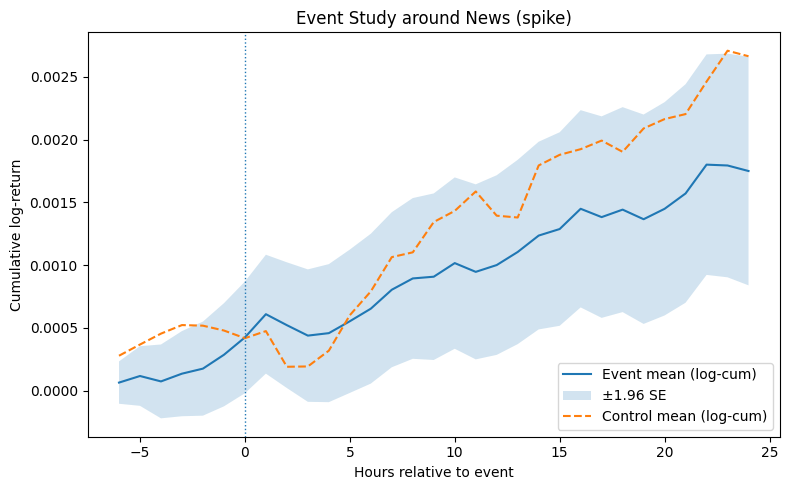

In [6]:
# ===================== CONFIG =====================
TF_LOWER = "1h"     # dùng chữ thường để tránh FutureWarning
PRE_H    = 6        # số giờ trước event (K-)
POST_H   = 24       # số giờ sau event (K+)
USE_SPIKE = True   # True: chỉ lấy event có news_spike=True; False: news_count>0
MIN_GAP  = 6        # tối thiểu cách nhau bao nhiêu giờ để coi là 2 event khác nhau
N_CONTROL = 2000    # số cửa sổ control để bootstrap baseline
RANDOM_SEED = 42

res = event_study(
    aligned,
    use_spike=USE_SPIKE,   # đổi True nếu muốn chỉ xét news_spike
    pre_h=PRE_H,
    post_h=POST_H,
    min_gap_hours=MIN_GAP,
    n_control=N_CONTROL,
    seed=RANDOM_SEED,
    plot=True,             # đặt False nếu chạy headless
)